# importing functions

In [114]:
import random
from itertools import count
from matplotlib.animation import FuncAnimation
import time
import matplotlib.pyplot as plt
import follow_road

%run localisation.ipynb
%run follow_road.py

In [115]:
# Import tdmclient Notebook environment:
import tdmclient.notebook

In [116]:
await tdmclient.notebook.start()

# Graphical functions

In [117]:
def draw_trajectory(traj) :
    #fig=plt.figure()
    #ax1=fig.add_subplot(111)
    #ax2=fig.add_subplot(221)
    xs, ys = zip(*traj)
    plt.plot(xs,ys)
    #ax1.set_aspect('equal')
    return

Unchecked Starred(value=Name(id='traj', ctx=Load()), ctx=Load())


In [118]:
def draw_thymio(pose) :
    move=pose[0:2]
    angle=pose[2]-math.pi/2
    thymio_shape=[[-0.5,-0.5],[0.5,-0.5],[0.5,0.25],[0,0.75],[-0.5,0.25]]
    
    thymio_shape.append(thymio_shape[0]) #repeat the first point to create a 'closed loop'
    rot=np.array([[np.cos(angle) , -np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    thymio_shape=(np.transpose((np.matmul(rot,np.transpose(100*np.array(thymio_shape))))))
    thymio_shape+=[move,move,move,move,move,move]
    xs, ys = zip(*thymio_shape) #create lists of x and y values
    fig=plt.figure(figsize=(8, 8), dpi=80)

    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    plt.xlim((0,1600))
    plt.ylim((0,1100))
    plt.plot(xs,ys)
    return thymio_shape

Unchecked Starred(value=Name(id='thymio_shape', ctx=Load()), ctx=Load())


In [119]:
def draw_now(pose,traj) :
    draw_thymio(pose)
    draw_trajectory(traj)
    plt.show()
    return


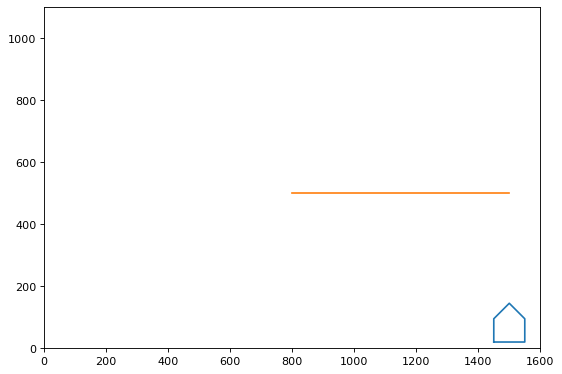

In [120]:
draw_now(S,trajnp)

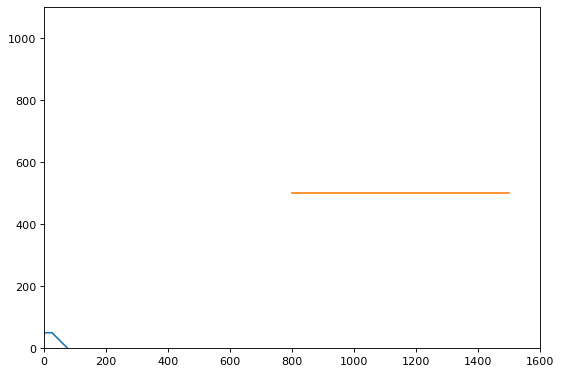

array([[-5.0000000e+01,  5.0000000e+01],
       [-5.0000000e+01, -5.0000000e+01],
       [ 2.5000000e+01, -5.0000000e+01],
       [ 7.5000000e+01,  4.5924255e-15],
       [ 2.5000000e+01,  5.0000000e+01],
       [-5.0000000e+01,  5.0000000e+01]])

In [121]:
thymio_shape=draw_thymio([0,0,0])
draw_trajectory(trajnp)
plt.show()
thymio_shape

# stop and turn approach

In [122]:
def inverse_kin(pose,obj) :
    global motor_left_target, motor_right_target
    angle_thres=math.pi/12
    angle=theta_des(pose,obj)
    error=angle-pose[2]
    if error>math.pi : 
        error-=2*math.pi
    if error< -(math.pi) :
        error+=2*math.pi
    speed=200
    coeff=100*5/math.pi # experimental value : half a turn with speed=100 takes 5 seconds
    t=abs(error)/speed*coeff
    
    vl=-np.sign(error)*speed
    vr=-vl
    motor_left_target = int(vl)
    motor_right_target = int(vr)
    
    time.sleep(2.5)
    
    motor_left_target = 0
    motor_right_target = 0
    return [vl,vr,t]
    

[-200.0, 200.0, 1.2500000000000002]


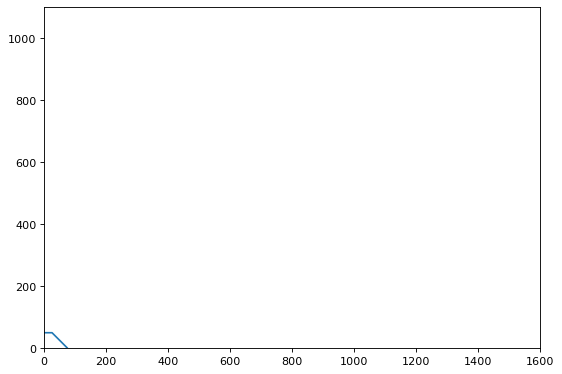

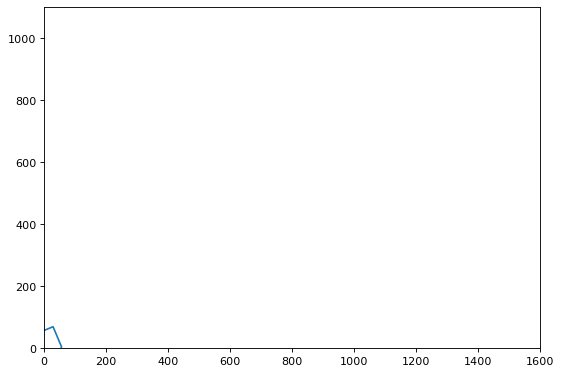

In [123]:
pose=[0,0,0]
draw_thymio(pose)
vl=vr=0
next_point=[0,500]

[vl,vr,dt]=inverse_kin(pose,next_point)
pose=kinematics2(pose,vl,vr,dt*1000)
draw_thymio(pose)
print([vl,vr,dt])

In [124]:
motor_left_target = int(vl)
motor_right_target = int(vr)
sleep(dt)
    
motor_left_target = 300
motor_right_target = 300
sleep(2)
motor_left_target = 0
motor_right_target = 0

In [125]:
t=float(0.5)
if 1 :
    motor_left_target = -100
    motor_right_target = 100
sleep(t)
motor_left_target = 100
motor_right_target = -100
sleep(t)
motor_left_target = 0
motor_right_target = 0

In [126]:
motor_left_target = 0
motor_right_target = 0

# PID controller

In [127]:
traj[0]
trajnp=np.array([[800,500],[1500,500]])
trajnp

array([[ 800,  500],
       [1500,  500]])

In [128]:
def PID(e,ediff,eint) :

    Kp=12
    Ki=0.05
    Kd=0
    correction=Kp*e+Ki*eint+Kd*ediff
    return correction

def theta_des(pos,obj) :
    '''
    orientation desired to face towards the goal
    
    '''
    return math.atan2(obj[1]-pos[1],obj[0]-pos[0])

def speed_des(pos,obj) :
    '''
    straight line speed desired, constant component + variable 
    component depending on distance to next point
    '''
    vbase=500
    coeff=0.5 # weight of variable component
    return vbase+coeff*math.sqrt((obj[1]-pos[1])**2+(obj[0]-pos[0])**2)

def wheel_inputs(omega,v) :
    '''
    calculates the motor speeds for the robot
    
    Arguments:
        - omega: correction, output of the PID
        - v: desired straight line speed
    Outputs:
        - [vl,vr]: left and right motor speeds 
    
    '''
    R=20 #wheel radius in [mm]
    L=95 #distance between wheels in [mm]
    vl=5*(2*v-omega*L)/(2*R) #left motor speed
    vr=5*(2*v+omega*L)/(2*R) #right motor speed
    
    #### setting lower and upper bounds ####
    if vr<0 :
        vr=max(-300,vr)
    else :
        vr=min(300,vr)
        
    if vl<0 :
        vl=max(-300,vl)
    else :
        vl=min(300,vl)

    
    return [int(vl),int(vr)]

def compute_error(pose,obj) : 
    angle=theta_des(pose,obj)
    error=angle-pose[2]
    if error>math.pi : 
        error-=2*math.pi
    if error< -(math.pi) :
        error+=2*math.pi
    return error

In [129]:
def follow_path(pose,trajectory,graph) :
    # following the path
    # initialisation 
    dt=0.1 # control period in [s]
    
    myPose=Pose(pose[0],pose[1],pose[2])
    
    nx_pt_id=0 # index of the next point to attain in the trajectory, set as 0 to start
    next_point=trajnp[nx_pt_id]
    
    prev_error=0 
    e_int=0
    
    distance_to_goal=dist(pose,trajnp[-1])
    
    iter=0

    while not(distance_to_goal < 5 and nx_pt_id==len(trajnp)-1) : # main control loop
        
        ########     get position    #######
        global prox_ground_delta, motor_left_target, motor_right_target, motor_left_speed, motor_right_speed
        #pose=kinematics2(pose,vl,vr,dt)
        myPose.update([motor_left_speed,motor_right_speed],prox_ground_delta,dt,myMap)
        pose=list(myPose.get_coords().values()) #pose in list form for low level functions
        #angle=theta_des(pose,next_point)
        v=speed_des(pose,next_point) 
        
        
        ########    call pid   ##########
        error=compute_error(pose,next_point)
        e_diff=(error-prev_error)/dt
        e_int+=error
        omega=PID(error,e_diff,e_int)

        #######  set wheel speeds    #######
        [vl,vr]=wheel_inputs(omega,v)
        motor_left_target = vl
        motor_right_target = vr
        sleep(dt)
        
        #####  check if arrived  ######
        if distance_to_goal < 5 and nx_pt_id==len(trajectory)-1 :
            break
        ##### update next point ######
        if dist(pose,next_point) < 5 and nx_pt_id<len(trajectory)-1 : 
            nx_pt_id+=1
            next_point=trajectory[nx_pt_id]

        #####  update distance to final point  #####
        distance_to_goal=dist(pose,trajectory[-1]) 


        #####    graph  ####
        if iter % 20 ==0 and graph: 
            print (myPose.get_coords())
            print(error,e_diff,e_int)
            print([vl,vr])
            print(distance_to_goal)
            print(dist(pose,next_point))
            #myPose.plot(plot_theta=False)
            draw_now(pose,trajnp)

    
        iter+=1
    motor_left_target=0
    motor_right_target=0
    print('arrive sain et sauf')
    return

{'x': 1500.0000045014212, 'y': 99.97932066222876, 'theta': 1.5712316812846054}
1.0511925910561846 10.511925910561844 1.0511925910561846
[75, 300]
400.0206793377713
806.2360387627447


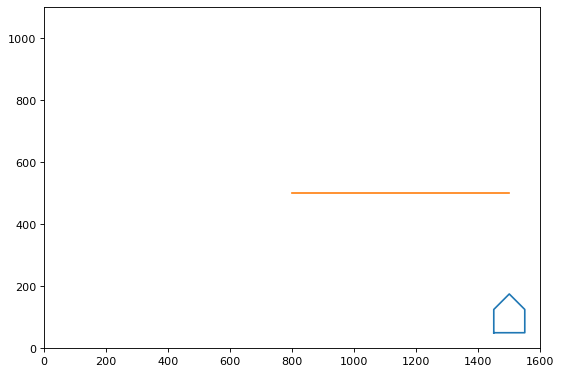

{'x': 1396.9660001213135, 'y': 216.22675757271958, 'theta': 2.683127048001292}
0.014724286682098242 0.14724286682098242 9.152648847548226
[200, 215]
301.89941743682317
660.980830598386


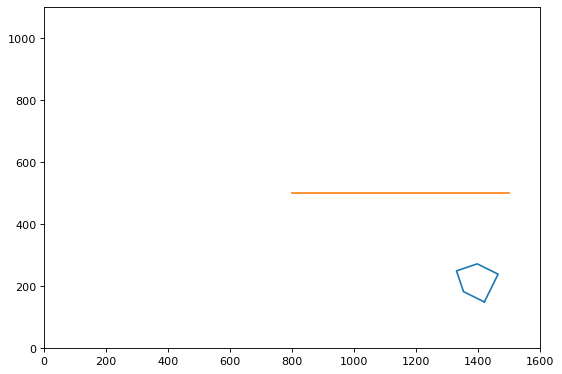

{'x': 1247.952988926072, 'y': 282.2782079365825, 'theta': 2.726589349995173}
-0.03741175622934456 -0.3741175622934456 8.524314896217135
[187, 186]
333.0622682481562
498.0608989140863


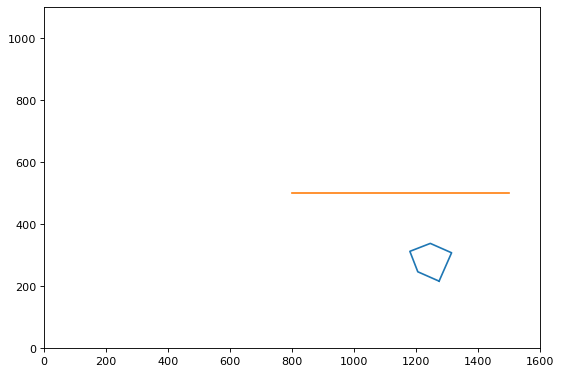

{'x': 1115.1740115723253, 'y': 342.4915404115743, 'theta': 2.7104227451733736}
-0.03227830844021451 -0.3227830844021451 7.859675523900527
[168, 169]
415.8124050713922
352.34013738504296


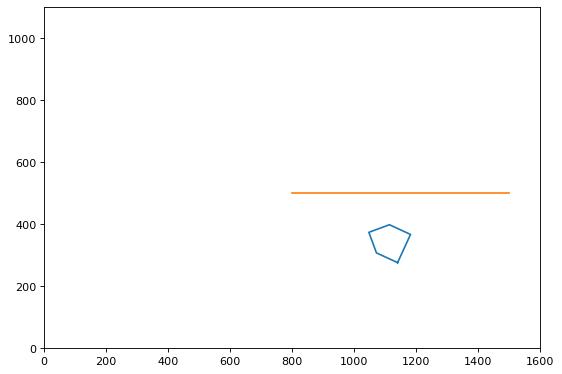

{'x': 993.4729424007511, 'y': 397.61403660948923, 'theta': 2.6995388829306495}
-0.04468037346622289 -0.4468037346622289 6.877027096065648
[154, 150]
516.7712700794771
218.89418663045248


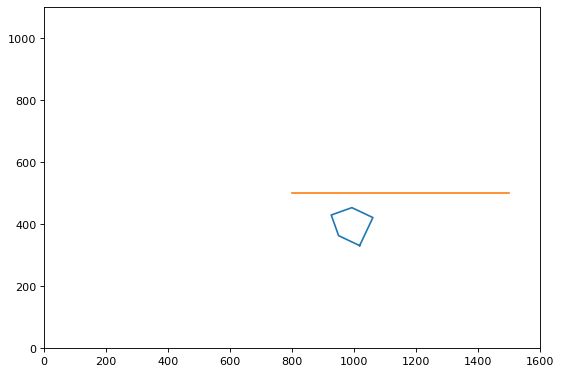

{'x': 886.5113005082737, 'y': 450.3271189205055, 'theta': 2.647514973140594}
-0.027138586662835973 -0.27138586662835973 5.927413534115299
[137, 137]
615.4963684042232
99.7577076238746


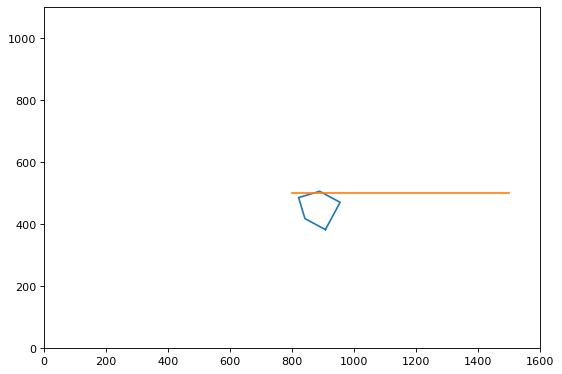

{'x': 791.5885962845165, 'y': 504.09971525817275, 'theta': 2.5666672172527987}
-2.5724543481048334 -25.724543481048332 -0.7346877980213367
[300, -153]
708.4232665429191
708.4232665429191


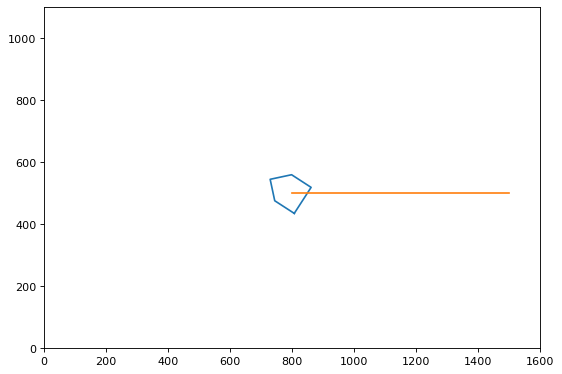

{'x': 858.7141826397801, 'y': 579.7493095161205, 'theta': 0.08234230873429169}
-0.20606557235075115 -2.0606557235075114 -23.742192983278034
[249, 162]
646.2255426054152
646.2255426054152


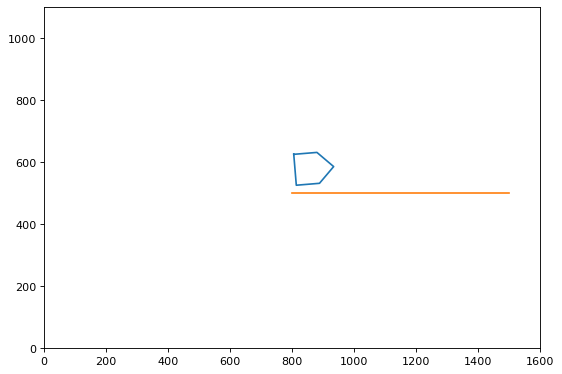

{'x': 1021.2530053175507, 'y': 546.5082092729725, 'theta': 6.114335470978524}
0.07200802013999574 0.7200802013999574 -22.259086815676707
[188, 182]
481.00072603610045
481.00072603610045


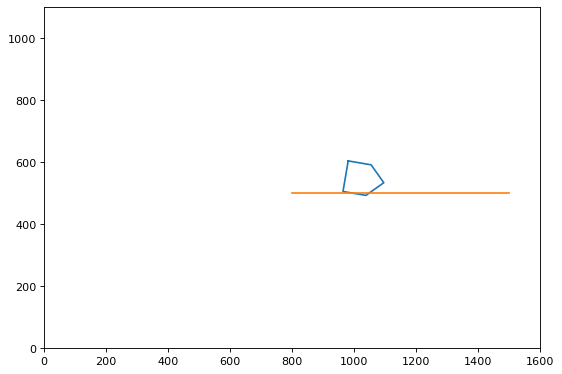

{'x': 1166.0303864274504, 'y': 520.5222389401911, 'theta': 6.122975137049195}
0.09883792067601149 0.9883792067601149 -20.306441875448442
[164, 168]
334.59955929575943
334.59955929575943


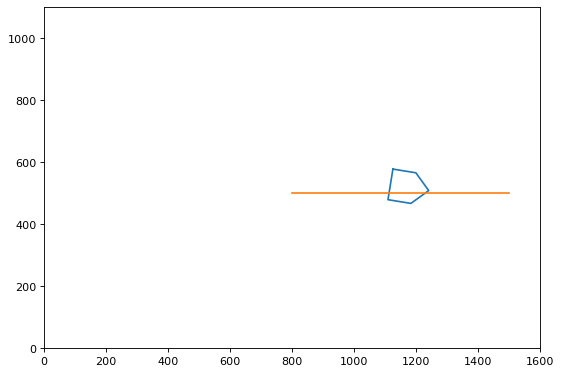

{'x': 1294.8587308623614, 'y': 501.7505011081363, 'theta': 6.166555045031072}
0.10809731980111703 1.0809731980111703 -18.12202103810624
[145, 155]
205.14873764547187
205.14873764547187


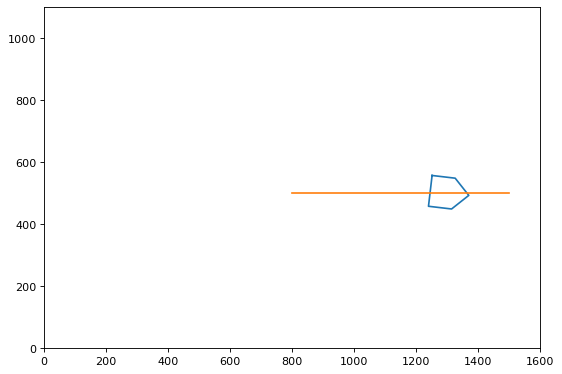

{'x': 1412.5198457114718, 'y': 492.71010884217594, 'theta': 6.252303247447056}
0.11402191004750595 1.1402191004750595 -15.932518094352783
[129, 142]
87.78336919620719
87.78336919620719


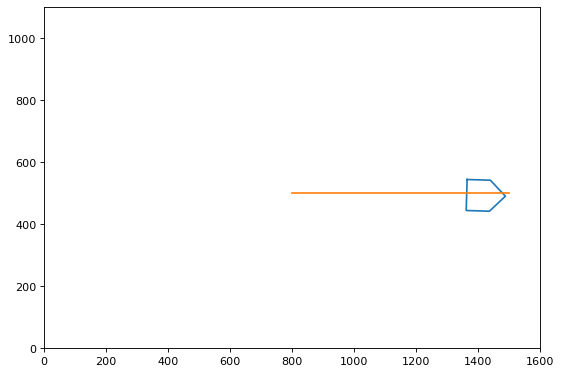

arrive sain et sauf


In [131]:
follow_path([1500,100,math.pi/2],trajnp,True)

In [104]:
motor_left_target=0
motor_right_target=0

In [103]:
5%3

2

array([[1400.,   20.],
       [1500.,   20.],
       [1500.,   95.],
       [1450.,  145.],
       [1400.,   95.],
       [1400.,   20.]])

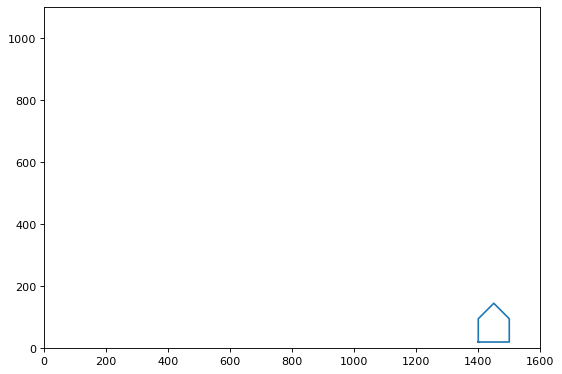

In [109]:
draw_thymio([1450,70,math.pi/2])